In [17]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import set_config
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras_tuner.applications import HyperResNet, HyperEfficientNet, HyperXception


from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.Q1.model_utils import *
from classification.Q2.CNN_utils import AudioUtil, Feature_vector_DS


"""
#Pipeline
#-------------------------
1. Dataset import -> get-dataset_matrix()
3. Data preparation -> get_dataset_()
2. Data split -> train_test_split()
3. Data scaling -> StandardScaler()
4. Data processing -> PCA?
5. Modelling -> Tensorflow CNNs (HyperEfficientNet, HyperResNet, HyperDenseNet, 
                HyperXception, HyperMobileNet), self-made)
6. Training and 7. Evaluation -> Tensorflow Keras tuner
8. Final_model -> perform_KFold, fit, predict, accuracy, confusion_matrix, classification_report
#-------------------------

Wanted to use sklearn pipeline but seems too restrictive compared to the benefits
"""
verbose = True


### 1. + 3. + 4. dataset import & preparation & processing

TO MODIFY:
 - All soundfiles must be recorded by the MCU
 - The function Feature_vector_DS must be replaced by the functions in the MCU (in C), it sould have the list of hyperparameters as an input
 - Data augmentation: add background noise augmentation (function already exists!)
  - Potentially concatenate all file from the same class then apply shifting?
 - Conditional normalisation if classes are concatenated?
 - Add possibility to visualize the dataset

Processing: creation of FV from dataset
- Potential PCA
- Time duration


In [18]:
import time

def get_dataset(Nft=512, nmel=20, duration=950, normalize=True, shift_pct=0, img_idx = 0, verbose=False, play_sound = False):
    """
    Load and initialize the dataset with necessary attributes.
    """
    dataset = Dataset()
    classnames = dataset.list_classes()
    print("number of sounds: ", len(dataset))

    myds = Feature_vector_DS(dataset, Nft=Nft, nmel=nmel, duration=duration, shift_pct=shift_pct, normalize=normalize)
    myds.data_aug = None  # Ensure no augmentation initially

    if verbose:
        fig, axs = plt.subplots(1, len(classnames), figsize=(len(classnames) * 4, 3))
        for i, ax in zip(range(len(classnames)), axs):
            #play the sound using display()
            ax.imshow(myds[classnames[i], img_idx].reshape((nmel, -1)), cmap="jet", origin="lower", aspect="auto")
            ax.set_title(classnames[i])
            ax.set_xlabel("")
            ax.set_ylabel("Mel bins")
        plt.colorbar(axs[-1].images[0], ax=axs, orientation='vertical')
        plt.show()
    if play_sound:
        for i in range(len(classnames)):
            myds.display([classnames[i], img_idx])
            time.sleep(duration/1000)
    
    return myds, dataset, classnames

def augment_dataset(myds, dataset, classnames, augmentations, nmel=20, load_matrix = False, verbose=False, img_idx=0, play_sound=False, duration=950):
    """
    Augment dataset and compute feature matrix.
    """
    train_pct = 1
    featveclen = len(myds["gun", 39])  # Number of items in a feature vector
    nitems = len(myds)  # Number of sounds in dataset
    naudio = dataset.naudio  # Number of audio files per class
    nclass = dataset.nclass  # Number of classes
    nlearn = round(naudio * train_pct)  # Training sample count

    myds.data_aug = augmentations
    data_aug_factor = len(augmentations)
    class_ids_aug = np.repeat(classnames, naudio * data_aug_factor)

    #Play augmentations of each class - TODO
    #if play_sound:
    #    for i in range(len(classnames)):
    #        myds.display([classnames[i], img_idx+naudio*i])
    #        time.sleep(duration/1000)

    if load_matrix:
        X_aug = np.load("feature_matrix_2D_aug.npy", allow_pickle=True)
        y_aug = np.load("labels_aug.npy", allow_pichkle=True)

    else:
        X_aug = np.zeros((myds.data_aug_factor * nclass * naudio, featveclen))
        y_aug = np.empty((myds.data_aug_factor * nclass * naudio,), dtype=object)
        
        for s in range(myds.data_aug_factor):
            for idx in range(dataset.naudio):
                for class_idx, classname in enumerate(classnames):
                    #print(classname, idx)
                    try:
                        featvec = myds[classname, idx]
                        X_aug[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
                        y_aug[s * nclass * naudio + class_idx * naudio + idx] = classname
                    except:
                        print(f"Error at {classname}, {idx}")
                        continue
        
        X_aug = X_aug / np.linalg.norm(X_aug, axis=1, keepdims=True)  # Normalize
        
        np.save("feature_matrix_2D_aug.npy", X_aug, allow_pickle=True)
        np.save("labels_aug.npy", y_aug, allow_pickle=True)

    if verbose:
        print(f"Shape of feature matrix: {X_aug.shape}")
        print(f"Number of labels: {len(y_aug)}")

        fig, axs = plt.subplots(1, len(classnames), figsize=(len(classnames) * 4, 3))
        j = 0
        for i, ax in zip(range(0, len(X_aug), len(X_aug) // len(classnames)), axs):
            ax.imshow(
                X_aug[i+img_idx].reshape((nmel, -1)),
                cmap="jet",
                origin="lower",
                aspect="auto",
            )
            ax.set_title(classnames[j])
            ax.set_xlabel("")
            ax.set_ylabel("Mel bins")
            j+=1
        plt.colorbar(axs[-1].images[0], ax=axs, orientation='vertical')
        plt.show()
    return X_aug, y_aug

number of sounds:  160


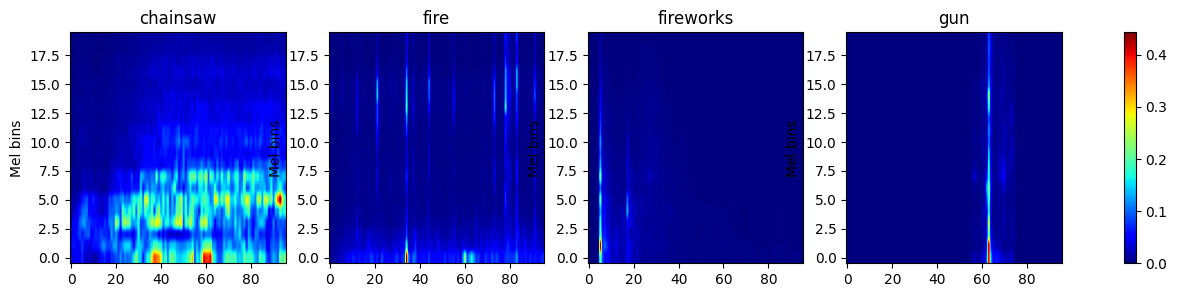

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


Shape of feature matrix: (1120, 1920)
Number of labels: 1120


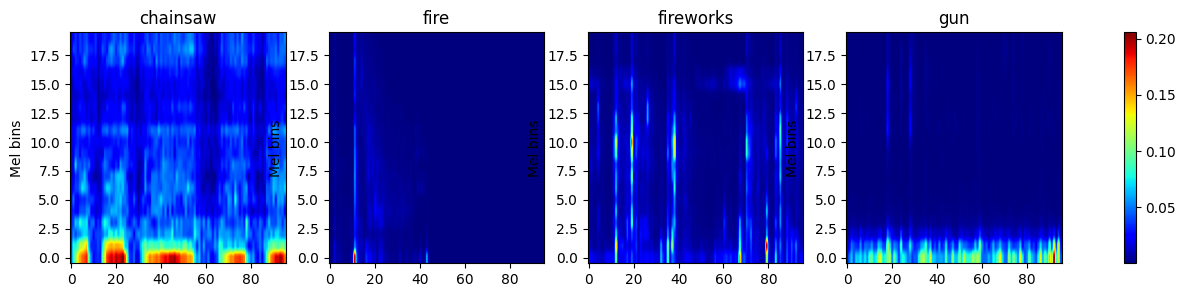

In [19]:
#TODO: TO IMPROVE: data augmentation
#Idea: concatenate all sounds of the same class, and create much more instances by using shift
## + Sound analysis: if soud not loud enough, set its label to "garbage"
## Also garbage if only noise / ambiant sound

img_idx = 38


#1. Import classical dataset - TO UPDATE FOR MCU RECORDINGS?
myds, dataset, classnames = get_dataset(
    Nft=512, nmel=20, duration=950, normalize=True, shift_pct=0, verbose=True, img_idx = 0, play_sound=True)

#PROBLEM: only 38 gun sounds and not 39
#CORRIGE A L'ARRAGE - Créé un 40e fichier


#3. Dataset augmentations - TO UPDATE
#TODO: adapter les graphe des augmentations pour montrer un exemple d'augmentations
#augmentations = []
augmentations = ["original","add_bg", "scaling", "time_shift", "add_noise", "add_echo"]
myds.mod_data_aug(augmentations)
# NORMALEMENT, la data augmentation doit être faite APRES le split train/test, mais demande de changer tt le code

X, y = augment_dataset(myds, dataset, classnames, augmentations, verbose=True, img_idx=img_idx,play_sound=True, duration=950)
#Remove background class from the dataset

# Transform the labels to integers and save mapping
label_to_id = {label: i for i, label in enumerate(classnames)}
id_to_label = {i: label for label, i in label_to_id.items()}
y = np.array([label_to_id[label] for label in y])

### 2. Data split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

if (verbose):
    print(f"Shape of the training matrix : {X_train.shape}")
    print(f"Number of training labels : {len(y_train)}")


Shape of the training matrix : (784, 1920)
Number of training labels : 784


### 3. Data preparation
Find if smthg to do here

### 5. Modelling

In [21]:


#A. HyperResNet
hyperResNet = HyperResNet(input_shape=X_train.shape[1:], classes=4)

#B. HyperEfficientNet
hyperEfficientNet = HyperEfficientNet(input_shape=X_train.shape[1:], classes=4)

#C. HyperXception
hyperXception = HyperXception(input_shape=X_train.shape[1:], classes=4)


#D Self-made 1
def self_made_builder(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape = X_train.shape[1:]))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=512, step=32)
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=512, step=32)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) 

    model.add(tf.keras.layers.Dense(units=hp_layer_1 , activation=hp_activation))
    model.add(tf.keras.layers.Dense(units=hp_layer_2 , activation=hp_activation))
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    # ⚠️ Always create a fresh optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01]))

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model



### 6. Training & 7. Evaluation

In [23]:
import keras_tuner as kt

tf.config.run_functions_eagerly(True)  # Force eager execution

from tensorflow.keras.utils import to_categorical

import pandas as pd
X_train = np.array(X_train, dtype=np.float32)
X_train = pd.DataFrame(X_train).apply(pd.to_numeric, errors='coerce')
X_train = X_train.fillna(0).values
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Convert labels to numbers

def create_tuner(hypermodel):
    return kt.Hyperband(self_made_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hp_dir',
                     project_name='tuner1')


#(A: HyperResNet, B: HyperEfficientNet, C: HyperXception, D: self_made_builder)
tuner = create_tuner(hyperXception)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 16s]
val_accuracy: 0.9299362897872925

Best val_accuracy So Far: 0.9617834687232971
Total elapsed time: 00h 03m 50s


In [24]:
from seaborn import heatmap

def show_confusion_matrix(y_predict, y_true, classnames, title=""):
    """
    From target labels and prediction arrays, sort them appropriately and plot confusion matrix.
    The arrays can contain either ints or str quantities, as long as classnames contains all the elements present in them.
    """
    plt.figure(figsize=(6, 6))  # Enlarged the figure size for better visibility
    
    # Compute confusion matrix
    confmat = confusion_matrix(y_true, y_predict)
    
    # Plot confusion matrix with enlarged annotations
    heatmap(
        confmat.T,
        square=True,
        annot=True,
        fmt="d",
        cbar=False,
        xticklabels=classnames,
        yticklabels=classnames,
        annot_kws={"size": 14},  # Increase font size for annotations
        ax=plt.gca(),
    )
    
    # Set larger font sizes for labels and title
    plt.xlabel("True label", fontsize=16)
    plt.ylabel("Predicted label", fontsize=16)
    plt.title(title, fontsize=18)
    
    # Enlarge tick labels
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
    # Display the plot
    plt.show()
    return None

def perform_kfold(model, X, y, k=5, epochs=5, batch_size=32):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_scores, recall_scores, f1_scores = [], [], []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
        y_pred = np.argmax(model.predict(X_val), axis=1)
        y_true = y_val if len(y_val.shape) == 1 else np.argmax(y_val, axis=1)
        
        report = classification_report(y_true, y_pred, output_dict=True)
        accuracy_scores.append(report['accuracy'])
        recall_scores.append(report['macro avg']['recall'])
        f1_scores.append(report['macro avg']['f1-score'])
    
    print(f"Mean Accuracy: {np.mean(accuracy_scores):.5f}")
    print(f"Mean Recall: {np.mean(recall_scores):.5f}")
    print(f"Mean F1-score: {np.mean(f1_scores):.5f}")

def evaluate_model(model, X_train, y_train, X_test, y_test, classnames):
    model.fit(X_train, y_train, epochs=5, validation_split=0.2, verbose=1)
    
    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1)
    y_true_train = y_train if len(y_train.shape) == 1 else np.argmax(y_train, axis=1)
    y_true_test = y_test if len(y_test.shape) == 1 else np.argmax(y_test, axis=1)
    
    print("Training results:\n---------------------")
    print(f"Accuracy on train set: {np.mean(y_pred_train == y_true_train):.5f}")
    print(f"Accuracy on test set: {np.mean(y_pred_test == y_true_test):.5f}")
    
    print("Confusion Matrix (Train):")
    show_confusion_matrix(y_pred_train, y_true_train, classnames, title="Confusion Matrix - Train")
    print("Confusion Matrix (Test):")
    show_confusion_matrix(y_pred_test, y_true_test, classnames, title="Confusion Matrix - Test")
    
    print("\nClassification Report:")
    print(classification_report(y_true_test, y_pred_test, target_names=classnames))


### 8. Final model

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.4492 - loss: 1.2048 - val_accuracy: 0.8089 - val_loss: 0.5900
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8556 - loss: 0.4633 - val_accuracy: 0.8599 - val_loss: 0.4409
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9017 - loss: 0.2751 - val_accuracy: 0.9299 - val_loss: 0.2902
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9756 - loss: 0.1273 - val_accuracy: 0.9363 - val_loss: 0.2130
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9757 - loss: 0.0721 - val_accuracy: 0.9236 - val_loss: 0.2857
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9543 - loss: 0.1367 - val_accuracy: 0.9299 - val_loss: 0.2691
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9894 - loss: 0.0474 - val_accuracy: 0.9427 - val_loss: 0.2471
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9935 - loss: 0.0184 - val_accuracy: 0.9427 - 

/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Mean Accuracy: 0.99236
Mean Recall: 0.99231
Mean F1-score: 0.99224
Epoch 1/5
 1/20 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.6011e-04

/home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9957 - loss: 0.0167 - val_accuracy: 0.9936 - val_loss: 0.0170
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9989 - loss: 0.0111 - val_accuracy: 1.0000 - val_loss: 0.0060
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9998 - loss: 0.0028 - val_accuracy: 0.9873 - val_loss: 0.0215
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9921 - loss: 0.0219 - val_accuracy: 0.9682 - val_loss: 0.0730
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9711 - loss: 0.0945 - val_accuracy: 0.9490 - val_loss: 0.1709
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Training results:
---------------------
Accuracy on train set: 0.96684
Accuracy on test set: 0.92262
Confusion Matrix (Train):


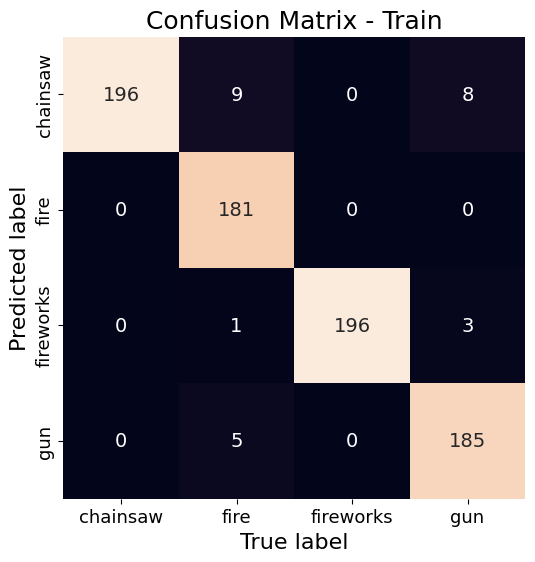

Confusion Matrix (Test):


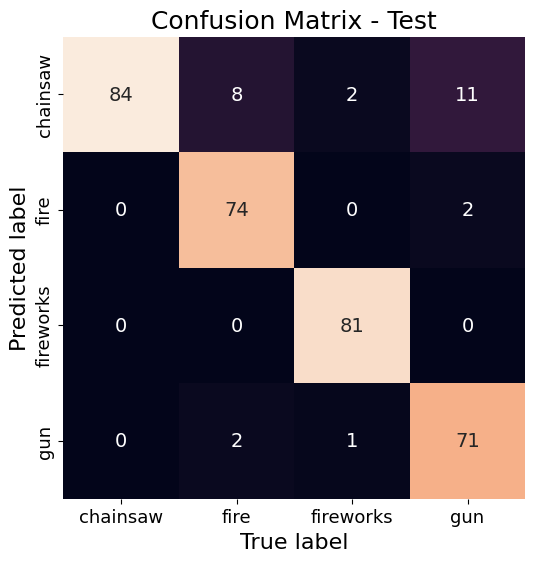


Classification Report:
              precision    recall  f1-score   support

    chainsaw       0.80      1.00      0.89        84
        fire       0.97      0.88      0.93        84
   fireworks       1.00      0.96      0.98        84
         gun       0.96      0.85      0.90        84

    accuracy                           0.92       336
   macro avg       0.93      0.92      0.92       336
weighted avg       0.93      0.92      0.92       336



[21:46:37] WARNING  You are saving your model as an HDF5 file via `model.save()` or                ]8;id=340565;file:///home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/keras/src/saving/saving_api.py\saving_api.py]8;;\:]8;id=307084;file:///home/martin/Documents/EPL/M1/Project-Embedded/LELEC210X/.venv/lib/python3.9/site-packages/keras/src/saving/saving_api.py#83\83]8;;\
                    `keras.saving.save_model(model)`. This file format is considered legacy. We                    
                    recommend using instead the native Keras format, e.g.                                          
                    `model.save('my_model.keras')` or `keras.saving.save_model(model,                              
                    'my_model.keras')`.                                                                            

In [26]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


#8. Final_model
#TODO: perform_KFold, fit, predict, accuracy, confusion_matrix, classification_report

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)


predictions = hypermodel.predict(X_test)

eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

# Perform K-Fold cross-validation
perform_kfold(model, X_train, y_train, k=5, epochs=5)

# Train and evaluate final model
evaluate_model(model, X_train, y_train, X_test, y_test, classnames)

model.save('model.h5')  # Saves in HDF5 format

